# [WIP] Example for using QuickFitSNAP
Author: Stefan Bringuier

### Description
This is notebooks is a work in progress (WIP) and trys to provide a potential path forward for generating SNAP interatomic potentials quickly using existing DFT data from existing high-throughput computational materials databases (ex. Materials Project) and [FitSNAP](https://fitsnap.github.io/). 

<div class="alert alert-block alert-info">
<b>Warning:</b> There are no gaurantees whatsoever on the quality of the potentials fit using this approach. This is very experimental!
</div>

### First steps
Frist need to add QuickFitSNAP modules to path.

In [4]:
%load_ext autoreload
%autoreload 2
import os
from os import getcwd
import sys
import glob
module_path = os.path.abspath(os.path.join('../')) # or the path to your source code
sys.path.insert(0, module_path);

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Grabbing data from databases
The premise of QuickFitSNAP is to grab various DFT calculation results from different high-throughput computational material science projects such as Materials Project and then fit a SNAP potential using that data. Therefore we want to have a fairly low effort approach to grabbing all possible calculations given a chemical system query.

At the momement there are classes to grab Materials Project and JARVIS databasee entries.

In [10]:
from quickfitsnap.dataio import GetAndWriteFitData
from quickfitsnap.matquery import MaterialsProjectQuery
from quickfitsnap.matquery import JARVISQuery
import getpass

Now energy your legacy materials project API key and make sure it is correct.

In [11]:
apikey = getpass.getpass()

 ········


Now perform a query of a chemical system in the format "X-Y", "X-Y-Z", etc., from the materials project or NIST JARVIS databases.

For now I'm going to just use the JARVIS database, and will ignore the Materials Project data since they share duplicate entries.

<div class="alert alert-block alert-info">
<b>Warning:</b> If you use both Materials Project and JARVIS databases you will need to delete similiar entries  using a function like below.
</div>

```python
from copy import deepcopy
def removeOverlapEntries(dataset1,dataset2,tasktype='DFT-SCF'):
    dtmp1,dtmp2 = deepcopy(dataset1),deepcopy(dataset2)
    d1_meta, _ = dtmp1
    d2_meta,d2_urls = dtmp2
    for d1 in d1_meta:
        ii = 0 # Increment over url of JARVIS calculations
        for i,j in enumerate(d2_meta.values()):
            for jj in j:
                if jj['task_id'] == d1 and jj['task_type'] == tasktype:
                    j.remove(jj)
                    del d2_urls[ii]
                else:
                    ii += 1       
    #Remove entry if list is empty
    delk = []
    for k in d2_meta:
        if not d2_meta[k]:
            delk.append(k)
    for k in delk:
        del d2_meta[k]

    return d2_meta,d2_urls
```

I'll grab data for Aluminum Phosphide, which is a widebandgap semiconductor. Keep in mind the query will grab unary and binary entries. If you don't want unary just pass the keyword argument `unary=False`.


<div class="alert alert-block alert-info">
<b>Note:</b> I'm using the MPRester legacy API, so you'll see a warning. Eventually the the new MPRester API will be used but some query features have changed at the moment.
</div>

In [12]:
chemsys = "Al-P"
mpquery = MaterialsProjectQuery(apikey,chemsys)
jquery = JARVISQuery(chemsys)

/home/stefanbringuier/.python-venv/atomistics/lib/python3.8/site-packages/pymatgen/ext/matproj.py:182: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40.8M/40.8M [00:03<00:00, 13.2MiB/s]


Loading the zipfile...
Loading completed.


Once queried, the calculation output file urls are available but need to be extracted from the query.

<div class="alert alert-block alert-info">
<b>Note:</b> The Materials Query only returns the mp-id no properties, where as the JARVIS query does include properties.
</div>

In [13]:
mp_meta,mp_urls = mpquery.getMPCalcOutFileInfo()
j_meta, j_urls = jquery.getJARVISCalcOutFileInfo()


/home/stefanbringuier/.python-venv/atomistics/lib/python3.8/site-packages/pymatgen/ext/matproj.py:182: UserWarning: You are using the legacy MPRester. This version of the MPRester will no longer be updated. To access the latest data with the new MPRester, obtain a new API key from https://materialsproject.org/api and consult the docs at https://docs.materialsproject.org/ for more information.
  warnings.warn(


For file patterns [['vasprun*', 'OUTCAR*', 'XDATCAR*']] and task_types [['GGA Static', 'GGA Structure Optimization', 'GGA NSCF Line', 'GGA+U Deformation', 'GGA+U Structure Optimization', 'GGA Deformation', 'SCAN Structure Optimization']], 
the following ids are not found on NOMAD [['mp-1413529', 'mp-1245152', 'mp-1244953', 'mp-1444877', 'mp-1245067', 'mp-1442110', 'mp-1429878', 'mp-1393326', 'mp-1245307', 'mp-1440816', 'mp-1245129', 'mp-1443516']]. 
If you need to upload them, please contact Patrick Huck at phuck@lbl.gov
Removing entries with no urls from meta data!.


There is an issue whereby if the pymatgen materials project MPRester can't grab the files from NOMAD for a given mp task_id then the meta info is still present which causes the iterate counter in GetAndWriteFitData to fail. Therefore a check in the method `getMPCalcOutFileInfo` grabs any `UserWarnings` and checks to see if what the materials project ids are and then removes them from the met data dict.

As metioned above, I'm not going to use the Materials Project data sets but its easy to combine meta data and url list for different data sets.

In [14]:
#meta = {**mp_meta,**j_meta}
#urls = mp_urls + j_urls
meta = j_meta
urls = j_urls

Now we need to actually grab the raw data. To do this I'll use the `GetAndWriteFitData` class to read download and read them. We can then use the `writefitfiles` method to output them for FitSNAP; in JSON or extXYZ format.

In [15]:
fitdata = GetAndWriteFitData(meta=meta,urls=urls,overwrite=True,outfrmt="extxyz",folderpath="AlP_XYZ")

<div class="alert alert-block alert-info">
<b>Note:</b> This can take a long time depending on how big the dataset is. Also it is up to you to manage where these files are finally located at based on the `folderpath`. The raw calculation files are initially downloaded to `/tmp`. This is mentioned here because you may want to resume fitting after you've queried and downloaded all the files and therefore no longer need the steps up till now.
</div>

So now we will write the fit data files to extended XYZ format.

In [16]:
#fitdata.folderpath=getcwd()+"/AlP_XYZ"
#fitdata.outfrmt='extxyz'
fitdata.writefitfiles()

Write XYZ Fit Dataset Files |████████████████████████████████████████| 24/24 [100%] in 1.1s (22.94/s)                   


Since we will most likely be doing other stuff in our python notebook/script related to FitSNAP, we can view the file locations (sans extension):

In [17]:
fitdata.outfilelist

['AlP_XYZ/Al4P4_JVASP-1327_mp-1550_FD-ELAST',
 'AlP_XYZ/AlP_JVASP-1327_mp-1550_DFT-SCF',
 'AlP_XYZ/Al2P2_JVASP-8182_mp-8880_FD-ELAST',
 'AlP_XYZ/Al2P2_JVASP-8182_mp-8880_DFT-SCF',
 'AlP_XYZ/Al4P4_JVASP-30519_mp-997569_FD-ELAST',
 'AlP_XYZ/Al4_JVASP-14615_mp-134_FD-ELAST',
 'AlP_XYZ/Al_JVASP-14615_mp-134_DFT-SCF',
 'AlP_XYZ/Al_JVASP-7148_mp-ase-Al_FD-ELAST',
 'AlP_XYZ/Al_JVASP-7148_mp-ase-Al_FD-ELAST',
 'AlP_XYZ/Al_JVASP-7148_mp-ase-Al_DFT-SCF',
 'AlP_XYZ/Al2_JVASP-25408_mp-998860_FD-ELAST',
 'AlP_XYZ/Al_JVASP-25408_mp-998860_DFT-SCF',
 'AlP_XYZ/Al4_JVASP-816_mp-134_FD-ELAST',
 'AlP_XYZ/Al_JVASP-816_mp-134_DFT-SCF',
 'AlP_XYZ/P8_JVASP-26_mp-blackP_FD-ELAST',
 'AlP_XYZ/P4_JVASP-26_mp-blackP_DFT-SCF',
 'AlP_XYZ/P4_JVASP-15781_mp-7245_FD-ELAST',
 'AlP_XYZ/P2_JVASP-15781_mp-7245_DFT-SCF',
 'AlP_XYZ/P_JVASP-7544_mp-ase-P_FD-ELAST',
 'AlP_XYZ/P_JVASP-7544_mp-ase-P_FD-ELAST',
 'AlP_XYZ/P_JVASP-7544_mp-ase-P_DFT-SCF',
 'AlP_XYZ/P2_JVASP-7547_mp-ase-P2_FD-ELAST',
 'AlP_XYZ/P2_JVASP-7547_mp-ase-P

## Setup and run FitSNAP
With the data set downloaded we can perform a fit and use Bayesian optimization package to adjust hyperparameters. To adjust the hyperparameters I will group the calculations into `DFT-SCF` and `FD-ELAST` which correspond to ground-state GGA calculations and Finite-difference elastic constant GGA calculations. For more specifics you'll want to look at the input files for the `JVASP`/`mp-#` entries.

In [19]:
from quickfitsnap.intface import SetupAndPerformFit
from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events;

## Prepare list of fitting data
Now we we prepare the list of fitting data groups and specify any defaults we want the input script for `FitSNAP` to have.


<div class="alert alert-block alert-info">
<b>Note:</b> The query and download will actually grab duplicate entries in the databases, if they exist. This doesn't cause an issue other than the `FitSNAP` input file `QuickFitSNAP` generates will have duplicate entries. We just remove these and no issue.
</div>

In [20]:

#Uncomment the lines below and comment the botton line if already grabbed the data
#outfilelist = [i.split('.xyz')[0] for i in glob.glob("./AlP_XYZ/*")]
#groups = set([i.split("AlP_XYZ/")[-1] for i in outfilelist]) # Remove duplicates that JARVIS returns
groups = set([i.split("AlP_XYZ/")[-1] for i in fitdata.outfilelist]) # Remove duplicates that JARVIS returns


In [27]:
inptfilesettings = {'numtypes':2,
                    'twojmax':[6,6],
                    'wj':[1.0,1.0],
                    'radelem':[0.5,0.5],
                    'species':['Al','P'],
                    'eshift':[0.0,0.0],
                    'masses':[[13,13],   #This is for the ZBL pair potential, bad kwarg name
                              [13,15],
                              [15,15]],
                    'metricfile':'AlP_FitSNAP_results.md',
                    'potfitname':"AlP_potential"}
qsf = SetupAndPerformFit(getcwd()+"/AlP_XYZ",groups,scraper='XYZ',copy_file=True,assignbycalctype=False,**inptfilesettings)

## Set default group weights for  Bayesian Opt

I need to find the structures from the list that are the structures with energy convex hull at 0.0, or the stable ground state structure. The reason is that I want these structures to basically be the only ones that have a eweight value, all the other structures should just be fitted for forces and stress.

Here I'm specifying how to weight the different structures. This is where we need domain knowledge on how we should assign weights and ranges. the kwarg `assignbytype=True` needs to bet set for below the hyperparameter tuning. Below the code, provides the dictionary neccessary to run `QuickFitSnap` object and to set the default values for the hyperparameters.

In [35]:
colnames = ['eweight','fweight','vweight']
pbounds = {}
for f in groups:
    for c in colnames:
        keyn = f+'_'+c
        if c == 'eweight':
            if 'DFT-SCF' in f:
                pbounds[keyn] = (1.0e2,1.0e3)
            else:
                pbounds[keyn] = (1.0e0,1.0e1)
        elif c == 'fweight':
            pbounds[keyn] = (1.0e0,5.0e2)
        elif c == 'vweight':
            pbounds[keyn] = (1.0e-12,1.0e-11)
## Here specify the SNAP potential bispectrum hyperparameters (i.e. cutoff)
## Note if you have more than 1 species you would use keys like 'twojmax_1', 'twojmax_2', etc.
pbounds['twojmax_1'] = (4,8)
pbounds['twojmax_2'] = (4,8)
pbounds['wj_1'] = (0.5,1.0)
pbounds['wj_2'] = (0.5,1.0)
pbounds['radelem_1'] = (0.5,1.1)
pbounds['radelem_2'] = (0.5,1.1)
pbounds['rcutfac'] = (2.8,4.8)
pbounds['rfac0'] = (0.9,1.0)

## Run Bayesian Opt of FitSNAP 

In [36]:
# Bayesian Optimization where runFitSNAP outputs a composite MAE as target
logger = JSONLogger(path="./AlP_bayes_opt_logs.json")
optim = BayesianOptimization(f=qsf.runFitSNAP,pbounds=pbounds,random_state=3,verbose=2)
optim.subscribe(Events.OPTIMIZATION_STEP, logger)
optim.maximize(init_points=2,acq='poi',n_iter=5);

Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on  17  testing on  0
Al4_JVASP-14615_mp-134_FD-ELAS

/tmp/ipykernel_29551/1353412952.py:5: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  optim.maximize(init_points=2,acq='poi',n_iter=10);


>>> Matrix of descriptors takes up  0.2699 % of the total memory: 8.1247 GB
'decorated_process_configs' took 11957.41 ms on rank 0


/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 52.13 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 41.67 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 32.23 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 30.74 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 31.60 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 41.94 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 31.70 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 45.99 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 30.86 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 32.67 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 30.60 ms on rank 0
Using LAMMPSSNAP as FitSNAP calculator
Al_JVASP-816_mp-134_DFT-SCF : Detected  3  fitting on  3  testing on  0
P8_JVASP-79517_mp-1064333_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-25267_mp-604573_DFT-SCF : Detected  15  fitting on  15  testing on  0
P24_JVASP-25087_mp-118_FD-ELAST : Detected  85  fitting on  85  testing on  0
P8_JVASP-7818_mp-157_FD-ELAST : Detected  19  fitting on  19  testing on  0
P4_JVASP-7818_mp-157_DFT-SCF : Detected  25  fitting on  25  testing on  0
Al2P2_JVASP-8182_mp-8880_FD-ELAST : Detected  21  fitting on  21  testing on  0
AlP_JVASP-1327_mp-1550_DFT-SCF : Detected  3  fitting on  3  testing on  0
P16_JVASP-7758_mp-12883_FD-ELAST : Detected  31  fitting on  31  testing on  0
P2_JVASP-15781_mp-7245_DFT-SCF : Detected  19  fitting on  19  testing on  0
P4_JVASP-25311_mp-674158_FD-ELAST : Detected  15  fitting on  15  testing on  0
P2_JVASP-7547_mp-ase-P2_FD-ELAST : Detected  17  fitting on 

/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: divide by zero encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))
/home/stefanbringuier/.python-venv/atomistics/src/fitsnap/fitsnap3lib/solvers/solver.py:169: RuntimeWarning: invalid value encountered in double_scalars
  rsq = 1 - ssr / np.sum(np.square(this_true - (this_true / nconfig).sum()))


'decorated_write_output' took 30.75 ms on rank 0


## Analyze

In [58]:
from fitsnap3lib.tools.dataframe_tools import DataframeTools
from IPython.display import Image
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
#plt.logging.getLogger('matplotlib.font_manager').disabled = True
import logging
mpl_logger = logging.getLogger()
mpl_logger.setLevel(logging.WARNING)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [46]:
df = DataframeTools("FitSNAP.df")
df.read_dataframe();

In [47]:
dfe  = df.df[df.df['Row_Type']=='Energy']
dff = df.df[df.df['Row_Type'] == 'Force']

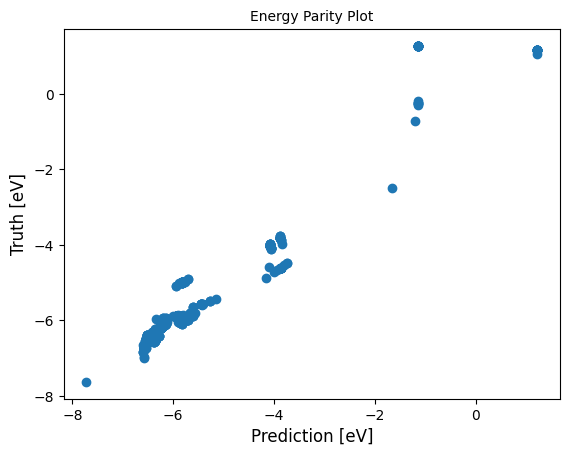

In [59]:
plt.title("Energy Parity Plot")
plt.xlabel("Prediction [eV]")
plt.ylabel("Truth [eV]")
plt.scatter(dfe['preds'],dfe['truths']);

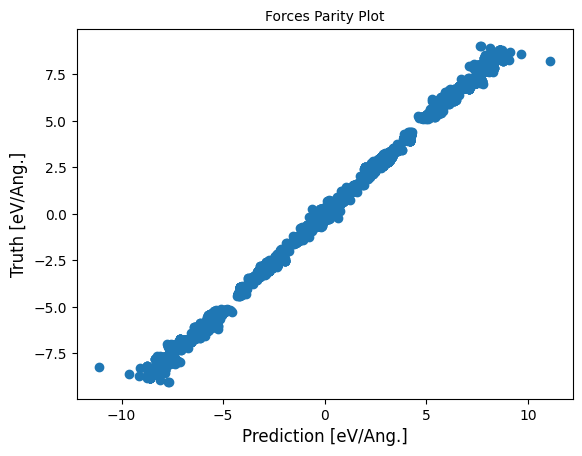

In [63]:
plt.scatter(dff['preds'],dff['truths'])
plt.title("Forces Parity Plot")
plt.xlabel("Prediction [eV/Ang.]")
plt.ylabel("Truth [eV/Ang.]");

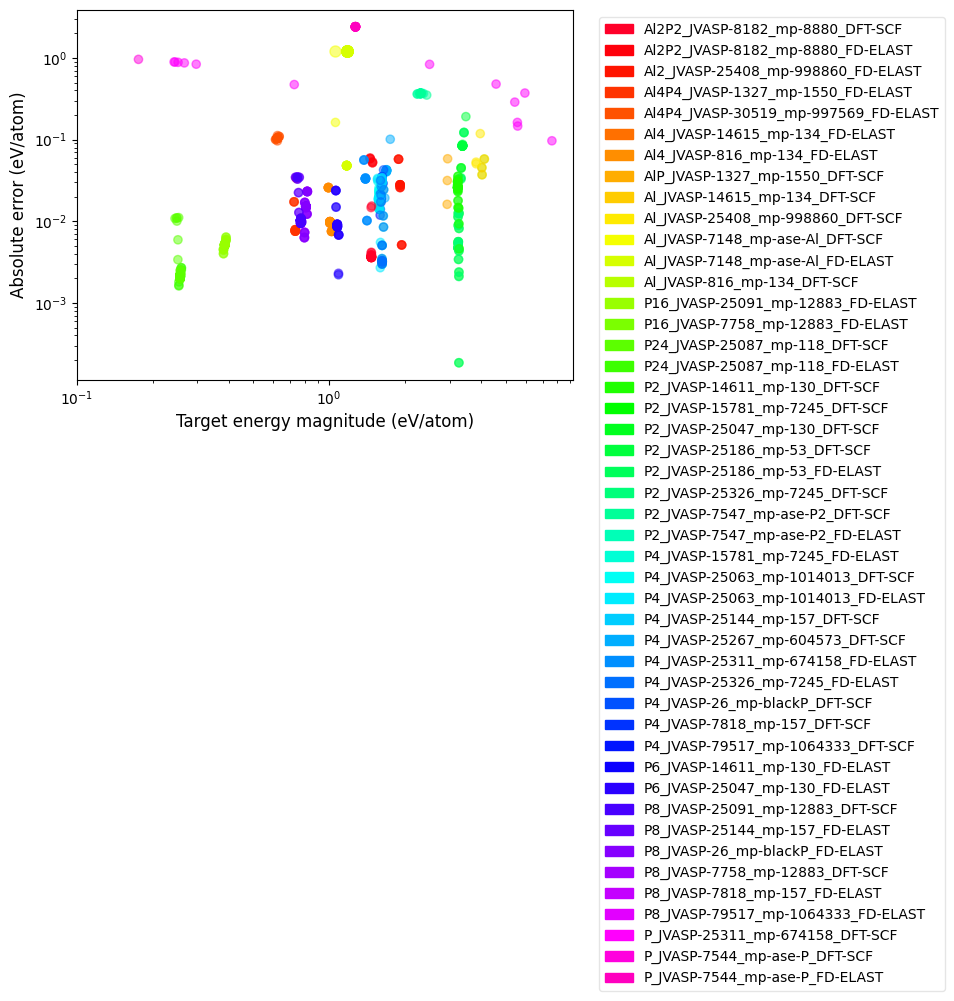

In [60]:
df.plot_agreement("Energy","Training")

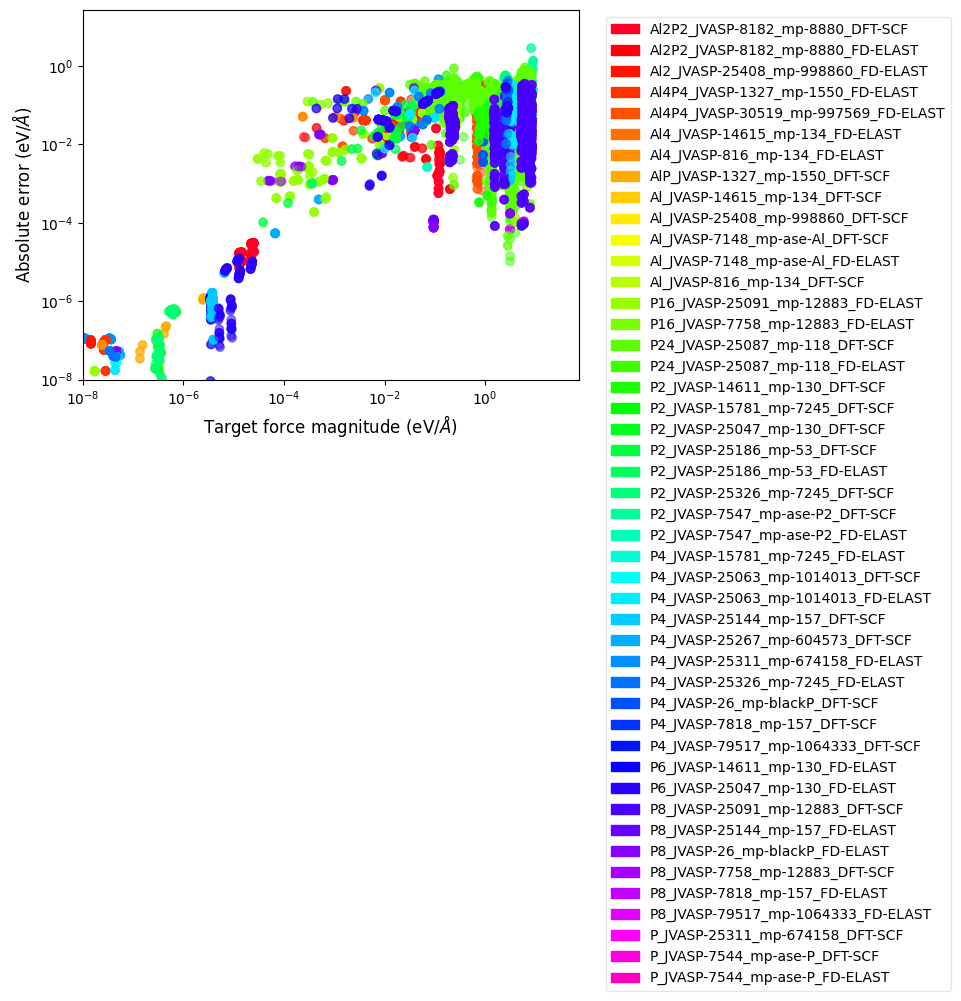

In [61]:
df.plot_agreement("Force","Training")